This notebook implements a Fully Connected MLP for the regression task.

In [1]:
# Standard Python Imports
import os
import json
import re
import string
import random
import time
import datetime
import matplotlib.pyplot as plt

# Extra non-standard utilities
from argparse import Namespace
from collections import Counter
from tqdm import tqdm

# Data management and Math imports
import numpy as np
import pandas as pd

# Torch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import copy

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression



In [2]:
args = Namespace(
    data_path = "./apartments_small.csv",
    train_split = 0.8,
    test_split = 0.2,
    val_split=0.25,
    seed=5059,
    batch_size=16,
    lr=0.001,
    epochs=100
)

# 1 Load in processed data

In [3]:
dataDir = "NumpyData/Apartment/"

In [4]:
X_train_processed = np.load(dataDir + 'X_train_prepared.npy')
X_test_processed = np.load(dataDir + 'X_test_prepared.npy')
X_val_processed = np.load(dataDir + 'X_val_prepared.npy')

y_train_processed = np.load(dataDir + 'y_train_prepared.npy')
y_test_processed = np.load(dataDir + 'y_test_prepared.npy')
y_val_processed = np.load(dataDir + 'y_val_prepared.npy')

y_train = np.load(dataDir + 'y_train.npy')
y_val = np.load(dataDir + 'y_val.npy')
y_test = np.load(dataDir + 'y_test.npy')

## 2 Scikit Learn Regression Model (For Reference)

In [19]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_processed, y_train)

lr_predictions_train = linear_regression.predict(X_train_processed)
linear_regression_mse_train = np.sqrt(mean_squared_error(y_train, lr_predictions_train))

lr_predictions_test = linear_regression.predict(X_test_processed)
linear_regression_mse_test = np.sqrt(mean_squared_error(y_test, lr_predictions_test))

In [20]:
print("Mean Squared Train Error : ", linear_regression_mse_train)
print("Mean Squared Test Error : ", linear_regression_mse_test)

Mean Squared Train Error :  555.3936466451042
Mean Squared Test Error :  718.2682255995378


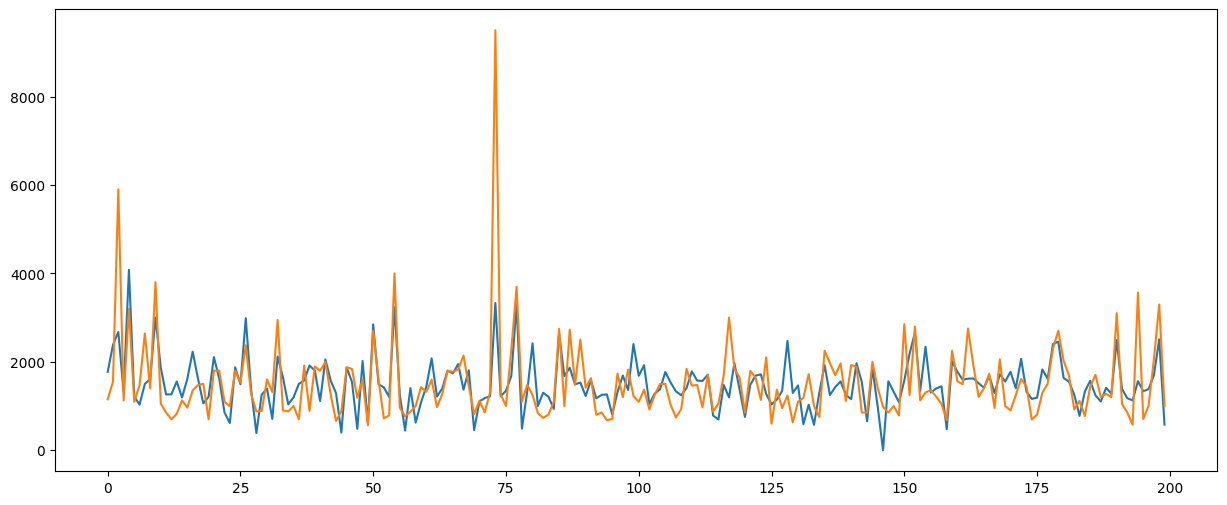

In [21]:
plt.figure(figsize=(15,6))

plt.plot([i for i in range(len(y_test))], lr_predictions_test)
plt.plot([i for i in range(len(y_test))], y_test)

# 3 Neural Network Implementation

## 3.1 Pytorch Dataset

In [5]:
class RegressionDataset(Dataset):
    ''' 
        Tensor dataset for torch NN training loop
    '''

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 3.2 Neural Network Model

In [6]:
class RegressionModel(nn.Module):
    ''' 
        Basic NN implementation
    '''

    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU(),
            nn.Linear(6, 1) # ensure single value output
        )

    def forward(self, x):
        return self.net(x)

## 3.3 General Train Function - Includes function to save weights

In [7]:
def train_model(model, train_loader, val_loader):
    loss_fn = nn.MSELoss()  # mean square error loss function
    optimizer = optim.Adam(model.parameters(), lr=args.lr) # adam optimizer

    train_loss_history = []
    val_loss_history = []

    best_loss = np.inf # initialize as infinity
    best_weights = None

    for epoch in tqdm(range(args.epochs), desc="Epochs", unit="epoch"):
        ''' 
            Train
        '''
        model.train() # Set model to training mode 
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad() # reset gradients for optimizer

            predictions = model(X_batch) # forward

            loss = loss_fn(predictions, y_batch) 
            loss.backward() # backward pass - compute loss gradients 

            optimizer.step() # update model parameters wrt loss gradients 

            train_loss += loss.item()        

        train_loss_history.append(train_loss)

        ''' 
            Validation
        '''
        model.eval() # set model to evaluation mode
        val_loss = 0
        with torch.no_grad(): # disable gradient computation (for efficiency)
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)

                val_loss += loss.item()

        val_loss_history.append(val_loss)

        ''' 
            Check if improvements made this epoch
        '''
        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())

    
    return {
        "train_loss_history" : train_loss_history,
        "val_loss_history": val_loss_history,
        "best_weights":best_weights,
        "best_loss" : best_loss
    }



## 3.4 Evaluation Functions

In [8]:
def plot_loss(loss_history, title):
    ''' 
        Plots loss trajectory across training epochs
    '''

    plt.figure(figsize=(8,4))
    plt.plot([i for i in range(len(loss_history))], loss_history)
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("Mean Square Error")
    plt.show()

In [9]:
def plot_predictions_vs_labels(X_test, y_test, y_pred):
    plt.figure(figsize=(10,6))
    plt.plot([i for i in range(len(X_test))], y_test, color="red", label="label")
    plt.plot([i for i in range(len(X_test))], y_pred, color="blue", label="predictions")
    plt.xlabel("Datapoints")
    plt.ylabel("Price")
    plt.legend()
    plt.show()



## 3.5 Setup Data - This time with validation

In [10]:
# Create Datasets
train_ds = RegressionDataset(X_train_processed, y_train)
val_ds = RegressionDataset(X_val_processed, y_val)
test_ds = RegressionDataset(X_test_processed, y_test)

# Create Dataloaders
train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=args.batch_size)
test_loader = DataLoader(test_ds, batch_size=args.batch_size)

## 3.6 Initialize Model

In [11]:
nn_model = RegressionModel(input_dim=X_test_processed.shape[1])

## 3.7 Train Model and Obtain Results

In [13]:
train_results = train_model(nn_model, train_loader, val_loader)

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.04epoch/s]


In [14]:
train_loss_history = train_results['train_loss_history']
val_loss_history = train_results['val_loss_history']
best_weights = train_results['best_weights']
best_loss = train_results['best_loss']

Best MSE Loss :  2609.527582365245


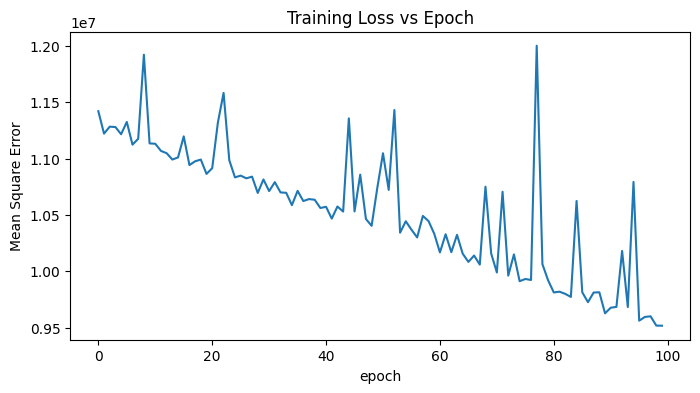

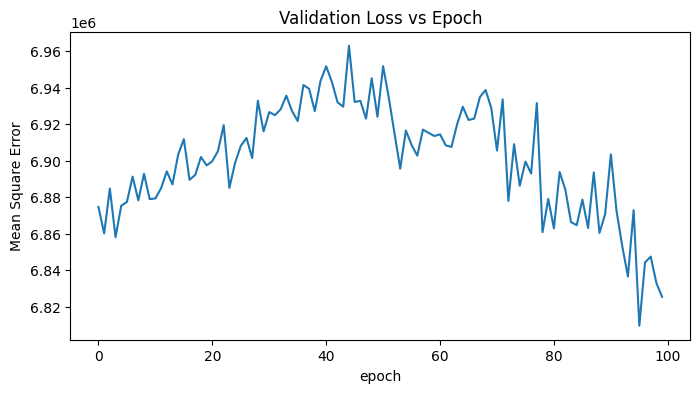

In [15]:
print("Best MSE Loss : ", np.sqrt(best_loss))

plot_loss(train_loss_history, "Training Loss vs Epoch")
plot_loss(val_loss_history, "Validation Loss vs Epoch")

In [16]:
nn_model.load_state_dict(best_weights)
nn_model.eval()

y_test_pred = nn_model(torch.tensor(X_test_processed, dtype=torch.float32))

mse_loss_fn = nn.MSELoss()

test_mse = mse_loss_fn(y_test_pred, torch.tensor(y_test.reshape(-1,1), dtype=torch.float32))

In [17]:
print("Best NN MSE Loss (TEST) : ", np.sqrt(test_mse.detach().numpy()))

Best NN MSE Loss (TEST) :  687.6306


In [22]:
print("LogReg MSE Loss (TEST) : ",linear_regression_mse_test)

LogReg MSE Loss (TEST) :  718.2682255995378


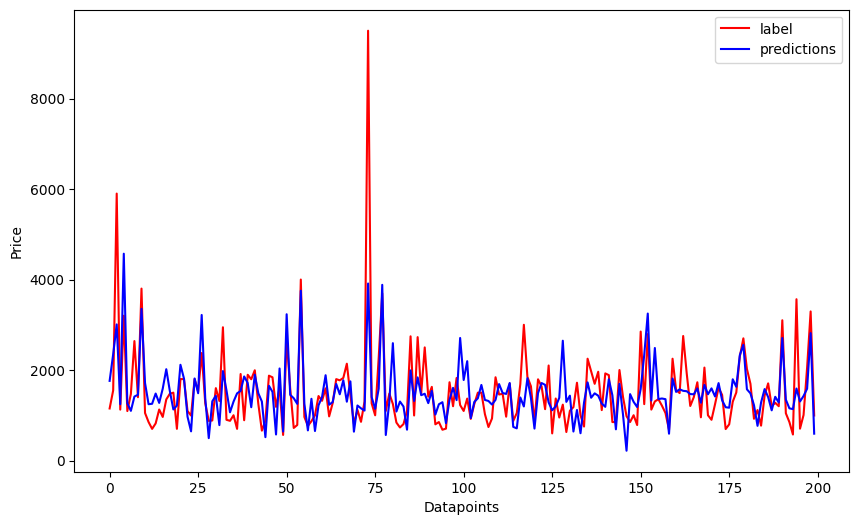

In [23]:
plot_predictions_vs_labels(X_test_processed, y_test, y_test_pred.detach().numpy())

# 3.8 Fine Tuning

NN Hyperparameters 
1) epochs 
2) batch size
3) learning rate 
4) loss function 
5) optimizer